In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal

In [2]:
limg = cv2.imread('left_image.jpg',0)
rimg = cv2.imread('right_image.jpg',0)


In [3]:
sift = cv2.xfeatures2d.SIFT_create()


In [4]:
kpl, des1 = sift.detectAndCompute(limg,None)
kpr, des2 = sift.detectAndCompute(rimg,None)


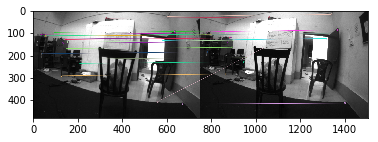

In [5]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match((des1*255).astype('uint8'),(des2*255).astype('uint8'))

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

img3 = np.zeros(limg.shape)
plt.imshow(cv2.drawMatches(limg,kpl,rimg,kpr,np.array(matches)[0:22], img3, flags=2))


In [6]:
cv2.imwrite('match.png', cv2.drawMatches(limg,kpl,rimg,kpr,np.array(matches)[0:22], img3, flags=2))

True

In [7]:

pts1 = []
pts2 = []
for i,m in enumerate(matches[:100]):
        pts2.append(kpr[m.trainIdx].pt)
        pts1.append(kpl[m.queryIdx].pt)
pts1 = np.array(pts1)
pts2 = np.array(pts2)


In [8]:
F,mask= cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)


In [9]:
pts1 = pts1[:,:][mask.ravel()==1]
pts2 = pts2[:,:][mask.ravel()==1]
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)


In [10]:
retBool ,rectmat1, rectmat2 = cv2.stereoRectifyUncalibrated(pts1,pts2,F,(limg.shape[1],limg.shape[0]))
limgr = cv2.warpPerspective(limg,rectmat1,(limg.shape[1]+200,limg.shape[0]))
rimgr = cv2.warpPerspective(rimg,rectmat2,(limg.shape[1]+200,limg.shape[0]))


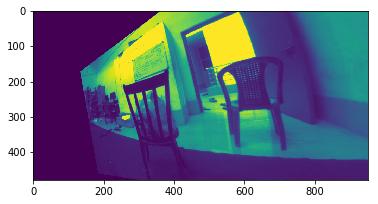

In [11]:
plt.imshow(rimgr)

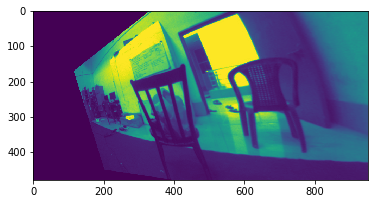

In [12]:
plt.imshow(limgr)

In [13]:
cv2.imwrite('limrs.png', limgr)
cv2.imwrite('rimrs.png', rimgr)

True

Manually choosen points

In [14]:
p1l = np.array([[215, 139], [256, 288], [440,272],[357,25]])
p2l = np.array([[(215+256)//2, (139+25)//2], [(215+256)//2, (288+272)//2], [(440+357)//2, (288+272)//2], [(440+357)//2, (139+25)//2]])
p1r = np.array([[228, 138], [368, 28], [423,279],[249,292]])
p2r = np.array([[(228+249)//2, (138+28)//2], [(368+423)//2, (138+28)//2], [(368+423)//2, (279+292)//2], [(228+249)//2, (279+292)//2]])


In [15]:
a = []
b = p2l.reshape(-1)
p5 = p1l
p6 = p2l
for ind, it in enumerate(p5):
    a.append([p5[ind][0],p5[ind][1],1,0,0,0, -p5[ind][0]*p6[ind][0] ,-p5[ind][1]*p6[ind][0]])
    a.append([0,0,0,p5[ind][0],p5[ind][1],1, -p5[ind][0]*p6[ind][1] ,-p5[ind][1]*p6[ind][1]])
soln = np.linalg.lstsq(a, b)[0]
ml = np.array([[soln[0], soln[1], soln[2]], [soln[3], soln[4], soln[5]], [soln[6], soln[7], 1]])
a = []
b = p2r.reshape(-1)
p5 = p1r
p6 = p2r
for ind, it in enumerate(p5):
    a.append([p5[ind][0],p5[ind][1],1,0,0,0, -p5[ind][0]*p6[ind][0] ,-p5[ind][1]*p6[ind][0]])
    a.append([0,0,0,p5[ind][0],p5[ind][1],1, -p5[ind][0]*p6[ind][1] ,-p5[ind][1]*p6[ind][1]])
soln = np.linalg.lstsq(a, b)[0]
mr = np.array([[soln[0], soln[1], soln[2]], [soln[3], soln[4], soln[5]], [soln[6], soln[7], 1]])
m = (ml+mr)/2
trimg = cv2.warpPerspective(rimgr, mr, (limgr.shape[1]-400, limgr.shape[0]))
tlimg = cv2.warpPerspective(limgr, ml, (limgr.shape[1]-400, limgr.shape[0]))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [16]:
cv2.imwrite('tlimg.png', tlimg)
cv2.imwrite('trimg.png', trimg)

True

In [17]:
stereo_bm = cv2.StereoBM_create(32,27)
dispmap_bm = stereo_bm.compute(tlimg,trimg)

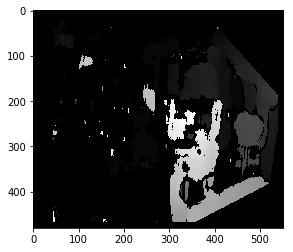

In [18]:
plt.imshow(dispmap_bm, cmap='gray')

In [19]:
cv2.imwrite('opencv-disparity-map.png', (dispmap_bm/np.max(dispmap_bm)*255).astype('int'))

True

In [20]:
nlimg = np.array(tlimg).astype('int')

nrimg = np.array(trimg).astype('int')
nstereo = np.zeros(tlimg.shape)
nlimg = nlimg - np.mean(nlimg)
nrimg = nrimg - np.mean(nrimg)


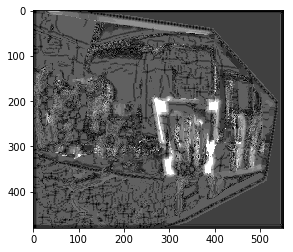

In [21]:
%matplotlib inline
import time
from scipy import ndimage
txsize = 5
tysize = 5
sxsize = 8
sysize = 8
f = 2
for x in range(0,nrimg.shape[0]):
    for y in range(0,nlimg.shape[1]):
        if y < tysize:
            yl = y
        elif y > nlimg.shape[1] - tysize:
            yl = nlimg.shape[1] - y
        else:
            yl = tysize
        if x < txsize:
            xl = x
        elif x > nlimg.shape[0] - txsize:
            xl = nlimg.shape[0] - x
        else:
            xl = txsize   
        
        if y < sysize:
            ys = y
        elif y > nlimg.shape[1] - sysize:
            ys = nlimg.shape[1] - y
        else:
            ys = sysize
        if x < sxsize:
            xs = x
        elif x > nlimg.shape[0] - sxsize:
            xs = nlimg.shape[0] - x
        else:
            xs = sxsize   
        
        template = nrimg[x-xl:x+xl + 1,y-yl:y+yl + 1].astype('int')
        sa = nlimg[x-xs:x+xs + 1,y-ys:y+ys + 1].astype('int')
        w, h = template.shape[::-1]
        template = np.flip(template,0)
        template = np.flip(template,1)
        transform = scipy.signal.fftconvolve(sa, template, mode='same')
        #transform = scipy.signal.fftconvolve(nrimg,template,mode='valid') 
        transform -= np.sum(template*template)
        transform = np.abs(transform)
        xf = np.unravel_index(transform.argmin(), transform.shape)[0] + x - xs
        yf = np.unravel_index(transform.argmin(), transform.shape)[1] + y - ys
        #print((x-xs),(y-ys))
        nstereo[x,y] = abs(xf - x) + abs(yf - y)
        #print((xf,yf))
plt.imshow(nstereo, cmap='gray')


In [22]:
cv2.imwrite('nstereo.png',  (nstereo/np.max(nstereo)*255).astype('int'))
nstereo = cv2.imread('nstereo.png')

In [23]:
nstereo2 = nstereo * (nstereo > 128)
nstereo3 = nstereo

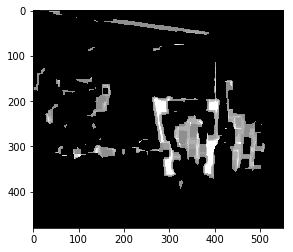

In [24]:
nstereo = cv2.dilate(nstereo2, None)
nstereo = cv2.dilate(nstereo, None)
nstereo = cv2.dilate(nstereo, None)
nstereo = cv2.dilate(nstereo, None)
nstereo = cv2.dilate(nstereo, None)
nstereo = cv2.erode(nstereo, None)
nstereo = cv2.erode(nstereo, None)
nstereo = cv2.erode(nstereo, None)
nstereo = cv2.erode(nstereo, None)
nstereo = cv2.erode(nstereo, None)
#nstereo = cv2.GaussianBlur(nstereo, (21, 21), 0)
plt.imshow(nstereo, cmap='gray')




In [25]:
cv2.imwrite('nstereo2.png', (nstereo/np.max(nstereo)*255).astype('int'))

True